In [5]:
import numpy as np
np.random.seed(13)

from IPython.display import SVG
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.visualize_util import model_to_dot, plot
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, base_filter
from gensim.models.doc2vec import Word2Vec

### k.mean( )で必要になるので追加
from keras import backend as K

In [6]:
base_filter()
path = get_file('alice.txt', origin="http://www.gutenberg.org/cache/epub/11/pg11.txt")
corpus = open(path).readlines()[0:200]

### new line more than 2 を削除
corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

### base_filter に ' を追加
tokenizer = Tokenizer(filters=base_filter()+"'")

### corpus を整形
tokenizer.fit_on_texts(corpus)

### corpus の型を sequence に変更（file 出力できなかった）
corpus = tokenizer.texts_to_sequences(corpus)

### sequence の合計を nb_samples に代入
nb_samples = sum(len(s) for s in corpus)

### 語彙数を数える
V = len(tokenizer.word_index) + 1

### 多分、特徴ベクトルの次元数
dim = 100

### 文脈窓
window_size = 2

In [7]:
### CBOW の定義
def generate_data(corpus, window_size, V):
    maxlen = window_size*2
    for words in corpus:
        
        ### リストを生成
        contexts = []
        labels   = []
        L = len(words)
        
        for index, word in enumerate(words):
            s = index-window_size
            e = index+window_size+1
            
            contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
            labels.append(word)
            
            ### x はシーケンス型
            x = sequence.pad_sequences(contexts, maxlen=maxlen)
            
            ### y は？
            y = np_utils.to_categorical(labels, V)

            yield (x, y)

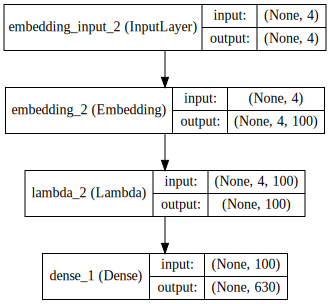

In [8]:
### ネットワーク構造をシーケンシャルに
cbow = Sequential()

### 入力層は Embeddding で固定次元に変換
cbow.add(Embedding(input_dim=V, output_dim=dim, init='glorot_uniform',input_length=window_size*2))

### 入力層の出力を、dim 次元ベクトルの平均値にする
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))

### dim 次元に変換された 4 つの単語を入力とする第二層
cbow.add(Dense(V, init='glorot_uniform', activation='softmax'))

###  スケーラブル・ベクター・グラフィックを生成、表示
SVG(model_to_dot(cbow, show_shapes=True).create(prog='dot', format='svg'))

In [9]:
### 学習過程の確認
cbow.compile(loss='categorical_crossentropy', optimizer="adadelta")

In [10]:
### 学習開始
for ite in range(10):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow.train_on_batch(x, y)
    print(ite, loss)

(0, 11706.892395019531)
(1, 10959.997585296631)
(2, 10518.412797451019)
(3, 10282.839844703674)
(4, 10125.285435676575)
(5, 10016.342594146729)
(6, 9907.9143269062042)
(7, 9783.0850994586945)
(8, 9649.9255139827728)
(9, 9519.4949787855148)


In [16]:
### 書き込み用ファイルを生成
f = open("vectors.txt", "w")

### 語彙数と特徴ベクトルの次元数を書き込む
f.write( " ".join([str(V-1), str(dim)]) )
f.write("\n")

In [17]:
vectors = cbow.get_weights()[0]

### 学習で得られた単語の特徴ベクトルを書き込む
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

In [18]:
w2v = Word2Vec.load_word2vec_format('./vectors.txt', binary=False)

In [19]:
w2v.most_similar(positive=['alice'])

[(u'she', 0.48996153473854065),
 (u'in', 0.3545055687427521),
 (u'a', 0.3302590548992157),
 (u'face\r', 0.33004695177078247),
 (u'it', 0.3296452760696411),
 (u'to\r', 0.3218887150287628),
 (u'who', 0.3210286498069763),
 (u'noticed', 0.31853413581848145),
 (u'about', 0.3024051785469055),
 (u'sister', 0.29495272040367126)]